<a href="https://colab.research.google.com/github/jojosam90/sms-spam-classifier/blob/main/LSTM_NLP_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LSTM for NLP : Text Classification**

https://www.kaggle.com/code/khotijahs1/using-lstm-for-nlp-text-classification

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('/content/drive/MyDrive/spam/SPAM text message 20170820 - Data.csv',delimiter=',',encoding='latin-1')
df = df[['Category','Message']]
df = df[pd.notnull(df['Message'])]
df.rename(columns = {'Message':'Message'}, inplace = True)
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df.shape

(5572, 2)

In [9]:
df.index = range(5572)
df['Message'].apply(lambda x: len(x.split(' '))).sum()

87265

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


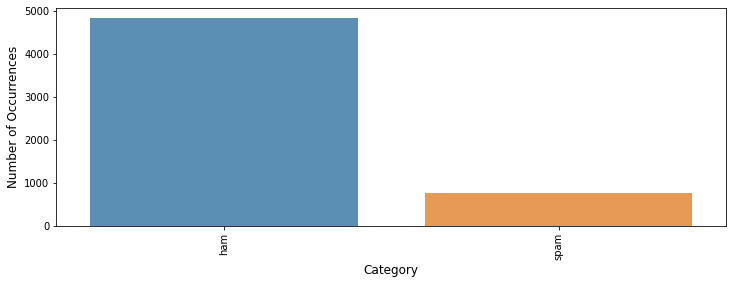

In [10]:
cnt_pro = df['Category'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [11]:
def print_message(index):
    example = df[df.index == index][['Message', 'Category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Message:', example[1])
print_message(12)

URGENT! You have won a 1 week FREE membership in our Â£100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18
Message: spam


In [12]:
print_message(0)

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Message: ham


In [13]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['Message'] = df['Message'].apply(cleanText)

In [18]:
df['Message'] = df['Message'].apply(cleanText)
train, test = train_test_split(df, test_size=0.000001 , random_state=42)
import nltk
from nltk.corpus import stopwords
# nltk.download('all')
from nltk.tokenize import word_tokenize
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.Category]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.Category]), axis=1)

# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))

Found 5572 unique tokens.


In [17]:
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5572, 50)


In [19]:
train_tagged.values

array([TaggedDocument(words=['and', 'also', 'i', "'ve", 'sorta', 'blown', 'him', 'off', 'a', 'couple', 'times', 'recently', 'so', 'id', 'rather', 'not', 'tet', 'him', 'out', 'of', 'the', 'blue', 'looking', 'for', 'weed'], tags=['ham']),
       TaggedDocument(words=['mmm', 'thats', 'better', 'now', 'i', 'got', 'a', 'roast', 'down', 'me', '!', 'iâ\x92d', 'b', 'better', 'if', 'i', 'had', 'a', 'few', 'drinks', 'down', 'me', '2', '!', 'good', 'indian', '?'], tags=['ham']),
       TaggedDocument(words=['mm', 'have', 'some', 'kanji', 'dont', 'eat', 'anything', 'heavy', 'ok'], tags=['ham']),
       ...,
       TaggedDocument(words=['prabha', '..', 'i', "'m", 'soryda', '..', 'realy', '..', 'frm', 'heart', 'i', "'m", 'sory'], tags=['ham']),
       TaggedDocument(words=['nt', 'joking', 'seriously', 'i', 'told'], tags=['ham']),
       TaggedDocument(words=['did', 'he', 'just', 'say', 'somebody', 'is', 'named', 'tampa'], tags=['ham'])],
      dtype=object)

In [20]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

/usr/local/lib/python3.8/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 5571/5571 [00:00<00:00, 1487173.34it/s]


In [21]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 5571/5571 [00:00<00:00, 1662857.07it/s]


CPU times: user 9.45 s, sys: 67.2 ms, total: 9.52 s
Wall time: 9.82 s


In [22]:
print(d2v_model)

Doc2Vec(dm/m,d20,n5,w8,s0.001)


In [23]:
len(d2v_model.wv.vocab)

9370

In [24]:
# save the vectors in a new matrix
embedding_matrix = np.zeros((len(d2v_model.wv.vocab)+ 1, 20))

for i, vec in enumerate(d2v_model.docvecs.vectors_docs):
    while i in vec <= 1000:
    #print(i)
    #print(model.docvecs)
          embedding_matrix[i]=vec
    #print(vec)
    #print(vec[i])

**Measuring distance between two vectors (related to cosine similarity)**

In [25]:
d2v_model.wv.most_similar(positive=['urgent'], topn=10)

[('11mths+', 0.7414788603782654),
 ('callertune', 0.7257471084594727),
 ('callers', 0.7246151566505432),
 ('denying', 0.7194780111312866),
 ('jealous', 0.7117162346839905),
 ('divert', 0.7029061317443848),
 ('09061743811', 0.700573742389679),
 ('wadebridge.i', 0.6984114050865173),
 ('whens', 0.6946920156478882),
 ('reserve', 0.6897503137588501)]

In [27]:
d2v_model.wv.most_similar(positive=['cherish'], topn=10)

[('okors', 0.7778984308242798),
 ('intrepid', 0.7766194939613342),
 ('semester', 0.7427587509155273),
 ('enjoyed', 0.73726886510849),
 ('dawns', 0.7369105219841003),
 ('duo', 0.732171893119812),
 ('holder', 0.7320700883865356),
 ('thank', 0.7320417761802673),
 ('pee', 0.724521815776825),
 ('abiola', 0.7165395021438599)]

**Create the LSTM Model**

In [28]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding


# init layer
model = Sequential()

# emmbed word vectors
model.add(Embedding(len(d2v_model.wv.vocab)+1,20,input_length=X.shape[1],weights=[embedding_matrix],trainable=True))

# learn the correlations
def split_input(sequence):
     return sequence[:-1], tf.reshape(sequence[1:], (-1,1))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(2,activation="softmax"))

# output model skeleton
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 189, 20)           187420    
                                                                 
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 201,722
Trainable params: 201,722
Non-trainable params: 0
_________________________________________________________________


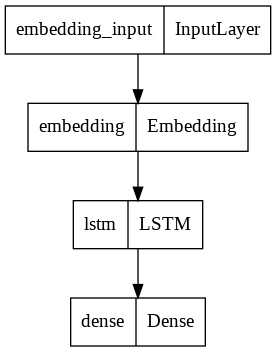

In [29]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [30]:
Y = pd.get_dummies(df['Category']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4736, 189) (4736, 2)
(836, 189) (836, 2)


In [31]:
batch_size = 32
history=model.fit(X_train, Y_train, epochs =50, batch_size=batch_size, verbose = 2)

Epoch 1/50
148/148 - 7s - loss: 0.2894 - acc: 0.9084 - 7s/epoch - 50ms/step
Epoch 2/50
148/148 - 1s - loss: 0.0496 - acc: 0.9869 - 1s/epoch - 7ms/step
Epoch 3/50
148/148 - 1s - loss: 0.0217 - acc: 0.9951 - 1s/epoch - 7ms/step
Epoch 4/50
148/148 - 1s - loss: 0.0164 - acc: 0.9960 - 1s/epoch - 7ms/step
Epoch 5/50
148/148 - 1s - loss: 0.0073 - acc: 0.9983 - 1s/epoch - 7ms/step
Epoch 6/50
148/148 - 1s - loss: 0.0035 - acc: 0.9992 - 1s/epoch - 7ms/step
Epoch 7/50
148/148 - 1s - loss: 0.0024 - acc: 0.9996 - 1s/epoch - 7ms/step
Epoch 8/50
148/148 - 1s - loss: 0.0015 - acc: 0.9996 - 1s/epoch - 7ms/step
Epoch 9/50
148/148 - 1s - loss: 9.4951e-04 - acc: 0.9998 - 1s/epoch - 7ms/step
Epoch 10/50
148/148 - 1s - loss: 6.6688e-04 - acc: 0.9998 - 1s/epoch - 7ms/step
Epoch 11/50
148/148 - 1s - loss: 5.5135e-04 - acc: 0.9998 - 1s/epoch - 7ms/step
Epoch 12/50
148/148 - 1s - loss: 4.1990e-04 - acc: 1.0000 - 1s/epoch - 7ms/step
Epoch 13/50
148/148 - 1s - loss: 3.9996e-04 - acc: 1.0000 - 1s/epoch - 7ms/step


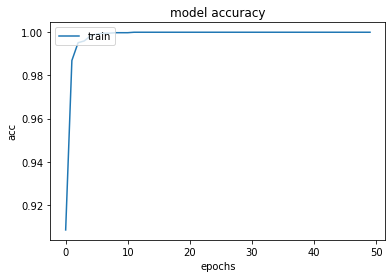

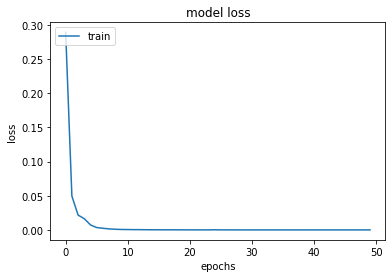

<Figure size 432x288 with 0 Axes>

In [32]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [35]:
# evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

148/148 - 1s - loss: 3.9026e-06 - acc: 1.0000 - 661ms/epoch - 4ms/step
27/27 - 0s - loss: 0.1257 - acc: 0.9868 - 130ms/epoch - 5ms/step
Train: 1.000, Test: 0.9868


In [42]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
#print(yhat_classes)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 1

[[1.0000000e+00 2.8862129e-13]
 [1.0000000e+00 3.3518559e-12]
 [1.0000000e+00 8.0022328e-13]
 ...
 [1.0000000e+00 2.8866972e-13]
 [1.0000000e+00 4.1107197e-13]
 [1.0000000e+00 1.9897953e-12]]


In [43]:
import numpy as np
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,

In [44]:
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(rounded_labels, yhat_classes)
# cm

In [45]:
validation_size = 200

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

20/20 [==============================] - 0s 10ms/step - loss: 0.1547 - acc: 0.9843
score: 0.15
acc: 0.98


In [46]:
model.save('Mymodel.h5')

In [47]:
message = ['Congratulations! you have won a $1,000 Walmart gift card. Go to http://bit.ly/123456 to claim now.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['ham','spam']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 24ms/step
[[4.2130497e-11 1.0000000e+00]] spam


In [48]:
message = ['thanks for accepting my request to connect']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['ham','spam']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 57ms/step
[[1.0000000e+00 3.3084676e-12]] ham
